<a href="https://colab.research.google.com/github/kameshcodes/deep-learning-codes/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


$$\textbf{Name Classification: RNN}$$

---

A character-level RNN reads words as a series of characters - outputting a $prediction$ and $hidden$ $state$ at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

In [15]:
import glob

def findFiles(path):
  return glob.glob(path)

path = "/content/drive/MyDrive/rnn-data/"
txt_path = path + "names/*txt"
print(findFiles(txt_path))

['/content/drive/MyDrive/rnn-data/names/Chinese.txt', '/content/drive/MyDrive/rnn-data/names/Dutch.txt', '/content/drive/MyDrive/rnn-data/names/Arabic.txt', '/content/drive/MyDrive/rnn-data/names/English.txt', '/content/drive/MyDrive/rnn-data/names/Czech.txt', '/content/drive/MyDrive/rnn-data/names/French.txt', '/content/drive/MyDrive/rnn-data/names/Italian.txt', '/content/drive/MyDrive/rnn-data/names/German.txt', '/content/drive/MyDrive/rnn-data/names/Irish.txt', '/content/drive/MyDrive/rnn-data/names/Japanese.txt', '/content/drive/MyDrive/rnn-data/names/Greek.txt', '/content/drive/MyDrive/rnn-data/names/Spanish.txt', '/content/drive/MyDrive/rnn-data/names/Scottish.txt', '/content/drive/MyDrive/rnn-data/names/Portuguese.txt', '/content/drive/MyDrive/rnn-data/names/Vietnamese.txt', '/content/drive/MyDrive/rnn-data/names/Russian.txt', '/content/drive/MyDrive/rnn-data/names/Polish.txt', '/content/drive/MyDrive/rnn-data/names/Korean.txt']


In [65]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(n_letters)

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )

print(unicodeToAscii('Ślusàrski'))
print(unicodeToAscii('Kamesh'))

57
Slusarski
Kamesh


In [ ]:
from io import open

category_lines = {}
all_categories = []

def readLines(filename):
  lines = open(filename, encoding='utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles(txt_path):
  category = filename.split('/')[-1].split('.')[0]
  all_categories.append(category)
  lines = readLines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

print(n_categories)
print(category_lines['Dutch'][:5])

18
['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven']


In [ ]:
category_lines['Arabic'][:5]

['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']

# Names -> Tensors

In [ ]:
def letterToIndex(letter):
  return all_letters.find(letter)

In [ ]:
import torch

def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor

In [37]:
def lineToTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li, letter in enumerate(line):
    tensor[li][0][letterToIndex(letter)] = 1
  return tensor

In [38]:
lineToTensor('Kamesh')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

# RNN Class

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    hidden = F.tanh(self.i2h(input)+self.h2h(hidden))
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [62]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(next_hidden)
print(output)

tensor([[-0.2661,  0.3001, -0.2272, -0.2451,  0.1159,  0.0854, -0.1009,  0.3022,
         -0.1759, -0.2956, -0.3299,  0.0420, -0.2040,  0.1345,  0.3496, -0.0114,
         -0.3252,  0.1473,  0.2629,  0.1881, -0.0329, -0.1377, -0.2695,  0.0715,
         -0.1510, -0.1712,  0.4469, -0.2007, -0.2881, -0.0532, -0.0649,  0.0170,
         -0.1599, -0.2390,  0.0620,  0.0361, -0.1199, -0.1336,  0.1227, -0.0318,
          0.3181,  0.0855,  0.2932,  0.2236,  0.0108,  0.2025, -0.0137, -0.0147,
         -0.3049, -0.1831,  0.0492, -0.4310,  0.2031, -0.3192,  0.3875, -0.0946,
          0.0912, -0.1629,  0.1177,  0.0817, -0.2130,  0.1855,  0.0316,  0.2244,
          0.1098,  0.3017, -0.0926,  0.1857,  0.0810,  0.2218,  0.3995, -0.0469,
         -0.0163,  0.4042,  0.2096,  0.0180, -0.2977,  0.1595,  0.0641, -0.0807,
         -0.1579,  0.0303, -0.2117,  0.2615,  0.1959, -0.1404, -0.1746,  0.2829,
         -0.1971,  0.1294, -0.3676,  0.2111,  0.1793,  0.1258, -0.1800, -0.0016,
         -0.1871, -0.0610, -

In [ ]:
!pip install torchviz -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.3 MB/s eta 0:00:00


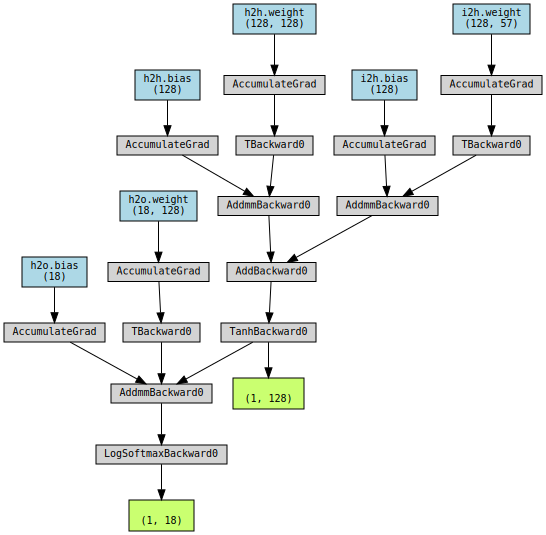

In [17]:
from torch.autograd import Variable
from torchviz import make_dot


input_size = 57
hidden_size = 128
output_size = 18
n_letters = input_size
n_categories = output_size

input_tensor = torch.randn(1, input_size)
hidden_tensor = torch.zeros(1, hidden_size)


output, next_hidden = rnn(input_tensor, hidden_tensor)


graph = make_dot((output, next_hidden), params=dict(rnn.named_parameters()))

display(graph)

In [39]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9380, -2.8233, -2.9013, -2.8975, -2.9458, -2.7789, -2.8396, -2.8704,
         -2.8855, -2.8916, -2.8130, -2.7616, -2.8700, -3.0242, -2.9093, -3.0116,
         -2.9321, -2.9784]], grad_fn=<LogSoftmaxBackward0>)


# $\textbf{Training}$

$\text{Index of Greatest Value}$

In [36]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 11)


$\text{Getting Training Examples}$

In [46]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print('category = ', category, '     /    line = ', line)

category =  Japanese      /    line =  Nozara
category =  Scottish      /    line =  Mccallum
category =  Spanish      /    line =  Ortiz
category =  Arabic      /    line =  Shadid
category =  French      /    line =  Germain
category =  German      /    line =  Behrends
category =  Dutch      /    line =  Veen
category =  Irish      /    line =  O'Toole
category =  Arabic      /    line =  Abadi
category =  Polish      /    line =  Andrysiak


$\textbf{Training}$

In [50]:
def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(input=output, target=category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-lr)
  return output, loss.item()

In [53]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

criterion = nn.NLLLoss()
lr = 0.005

def timeSince(since):
  now = time.time()
  s = now - since
  m = math.floor(s/60)
  s = s - m * 60
  return f'{m}m {int(s)}s'

start = time.time()

for iter in range(1, n_iters+1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if iter % print_every == 0:
    guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 5% (0m 10s) 0.4390 White / Scottish ✓
10000 10% (0m 21s) 0.1629 Kassis / Arabic ✓
15000 15% (0m 32s) 1.7176 Wallace / Irish ✗ (Scottish)
20000 20% (0m 42s) 0.1904 Si / Korean ✓
25000 25% (0m 52s) 0.0441 Hanania / Arabic ✓
30000 30% (1m 4s) 0.6878 She / Chinese ✓
35000 35% (1m 15s) 0.3161 Skala / Polish ✓
40000 40% (1m 26s) 1.0355 Kang / Chinese ✓
45000 45% (1m 36s) 1.7411 Duval / Czech ✗ (French)
50000 50% (1m 46s) 0.0045 Antoniadis / Greek ✓
55000 55% (1m 57s) 0.0074 Nakamura / Japanese ✓
60000 60% (2m 8s) 0.0806 Qiao / Chinese ✓
65000 65% (2m 18s) 1.9691 Gooding / German ✗ (English)
70000 70% (2m 29s) 0.0063 Vingovatov / Russian ✓
75000 75% (2m 40s) 0.1248 Chang / Korean ✓
80000 80% (2m 51s) 0.0028 Thuy / Vietnamese ✓
85000 85% (3m 1s) 0.7642 Shannon / Irish ✓
90000 90% (3m 12s) 1.1399 Peter / Czech ✗ (Dutch)
95000 95% (3m 22s) 0.1311 Christakos / Greek ✓
100000 100% (3m 33s) 0.5746 Chung / Vietnamese ✓


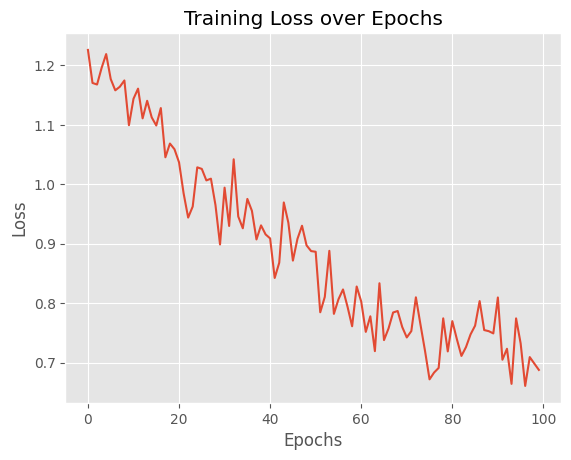

In [55]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure()
plt.plot(all_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

## $\textbf{Evaluate}$

In [56]:
confusion = torch.zeros(n_categories, n_categories)

n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  return output

In [58]:
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

<ipython-input-61-a3de753772b0>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-61-a3de753772b0>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


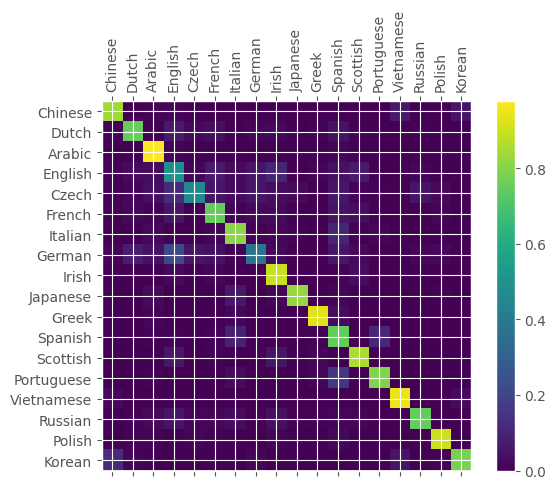

In [61]:
import matplotlib.ticker as ticker

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

plt.show()